In [25]:
import torch
import sympy as sp
import numpy as np
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import linalg
import sklearn
from sklearn import preprocessing
import scipy 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [26]:
# -*- coding: utf-8 -*-
import numpy as np
# ----------------------------------------------------------------------------------------------------------
# Globale Einstellungen für die physikalische Simulation für 4-Tanksystem bestehend aus Versuchsstand 2 u. 3
# ----------------------------------------------------------------------------------------------------------
# Dabei ist der obere Versuchsstand V3 und der untere V2
# Bei den Ventilabflüssen wird folgende Nomenklatur verwendet: 
# Prefix immer AS dann zwei Zahlen: erste Zahl = welcher Tank, zweite Zahl = welches Ventil

# Pumpe
Ku1 = 2.1e-5                 # m**3 / (s V) - Verstärkung der Pumpe 1
Ku2 = 2.3e-5                 # m**3 / (s V) - Verstärkung der Pumpe 2
uA01 = 7.0                  # V - Spannung ab welcher die Pumpe 1 Wasser fördert 
uA02 = 6.0                  # V - Spannung ab welcher die Pumpe 2 Wasser fördert 
uAmax1=12.0                 # Maximalspannung Pumpe 1
uAmax2=12.0                 # Maximalspannung Pumpe 2

# Tank 1 (Tank 1 V3)
rT1 = 0.060195545420039      # m - effektiver Radius des Tank 1 V2
AT1 = np.pi * rT1 ** 2       # m**2 - Tankquerschnitt 1
AS13 = 3.5e-05          # m**2 - Abflussquerschnitt von Tank 1 - Ventil11 zu Tank 3 mit 2.75 Umdrehung geschlossen
AS12 = 1e-05          # m**2 - Abflussquerschnitt von Tank 1 - Ventil12 zu Tank 2 mit 2.75 Umdrehung geschlossen
hV1 = 0.055                  # m - Höhe zwischen Nullniveau und Ventil
hT1 = 0.3                    # m - Höhe Tank 1

# Tank 2 (Tank 1 V2)
rT2 = 0.060195545420039      # m - effektiver Radius des Tank 1 V3
AT2 = np.pi * rT2 ** 2       # m**2 - Tankquerschnitt 2
hV2 = 0.055                  # m - Höhe zwischen Nullniveau und Ventil
hT2 = 0.3                    # m - Höhe Tank 2
AS23 = 1.5e-05          # m**2 - Abflussquerschnitt von Tank 2 - Ventil11 zu Tank 3 mit 2.00 Umdrehung geschlossen
AS24 = 3e-05          # m**2 - Abflussquerschnitt von Tank 2 - Ventil12 zu Tank 4 mit 2.75 Umdrehung geschlossen

# Tank 3 (Tank 2 V3)
rT3 = 0.060195545420039      # m - effektiver Radius des Tank 2 V2
AT3 = np.pi * rT3 ** 2       # m**2 - Tankquerschnitt 3
hV3 = 0.055                  # m - Höhe zwischen Nullniveau und Ventil
hT3 = 0.3                    # m - Höhe Tank 3
AS34 = 1e-05          # m**2 - Abflussquerschnitt von Tank 3 - Ventil22 zu Tank 4 mit 2.00 Umdrehungen geschlossen
AS30 = 3e-05          # m**2 - Abflussquerschnitt von Tank 3 - Ventil21 zu Reservoir mit 2.75 Umdrehungen geschlossen

# Tank 4 (Tank 2 V2)
rT4 = 0.060195545420039      # m - effektiver Radius des Tank 2 V3
AT4 = np.pi * rT4 ** 2       # m**2 - Tankquerschnitt 4
hV4 = 0.055                  # m - Höhe zwischen Nullniveau und Ventil zwischen Tank 4 und Reservoir
hT4 = 0.3                    # m - Höhe Tank 4
AS40 = 4e-05          # m**2 - Abflussquerschnitt von Tank 4 - Ventil22 zu Reservoir mit 2.00 Umdrehungen geschlossen

g = 9.81                     # m / s**2 - Erdbeschleunigung

scale = 2                    # Skalierung für die Visualisierung


initial_state = [0, 0, 0, 0]


In [27]:
# Steady state value symbolic calculation
# We assume that the heights x3 and x4 are static
# Since x4 and x4 are the flat variables of our three tank system we can 
# describe all other variables using these two variables

x3_bar, x4_bar = sp.symbols('x3_bar x4_bar')
Q_30 = AS30 * sp.sqrt(2 * g * (x3_bar + hV3))
Q_34 = AS34 * sp.sqrt(2 * g * (x3_bar + hV3))
Q_40 = AS40 * sp.sqrt(2 * g * (x4_bar + hV4))

x2_bar = (1 / AS24 * (Q_40 - Q_34)) ** 2 * 1 / (2 * g) - hV2
Q_24 = AS24 * sp.sqrt(2 * g * (x2_bar + hV2))
Q_23 = AS23 * sp.sqrt(2 * g * (x2_bar + hV2))

x1_bar = (1 / AS13 * (Q_30 + Q_34 - Q_23)) ** 2 * 1 / (2 * g) - hV1
Q_12 = AS12 * sp.sqrt(2 * g * (x1_bar + hV1))
Q_13 = AS13 * sp.sqrt(2 * g * (x1_bar + hV1))

Q_01 = Q_12 + Q_13
Q_02 = Q_23 + Q_24 - Q_12

U_A1 = Q_01 / Ku1 + uA01
U_A2 = Q_02 / Ku2 + uA02

# Check conditions for positive volume flow and voltage below 12
#positive_flow_condition = np.all(np.stack([Q_30 > 0, Q_34 > 0, Q_40 > 0, Q_24 > 0, Q_23 > 0, Q_12 > 0, Q_13 > 0, Q_01 > 0, Q_02 > 0]), axis=0)
#voltage_condition = np.all(np.stack([U_A1 < uAmax1, U_A2 < uAmax2]), axis=0)
# Get the indices where both conditions are satisfied
#indices = np.where(positive_flow_condition & voltage_condition)

#if indices[0].size > 0:
#        print(f"Array {i+1}: Plotting selected elements where all volume flows are positive, and voltage is below 12.")
#
#        # Accessing elements at the specified indices
 #       Q_30_selected = Q_30[indices]
#       Q_34_selected = Q_34[indices]
#        U_A_selected = U_A1[indices]  # Using U_A1 since it corresponds to Q_01
#
        # Plotting Q against voltage
#       plt.scatter(U_A_selected, Q_30_selected, label='Q_30', marker='o')
#        plt.scatter(U_A_selected, Q_34_selected, label='Q_34', marker='o')
#        # Repeat this for other Q arrays

#        plt.xlabel('Voltage (U_A1)')
 #       plt.ylabel('Volume Flow (Q)')
#        plt.title(f'Array {i+1} - Positive Volume Flows and Voltage below 12')
 #       plt.legend()
 #       plt.show()
print("U_A1 = " + str(U_A1) + "\n")

print("U_A2 = " + str(U_A2) + "\n")



U_A1 = 10.8476251054776*sqrt((sqrt(x3_bar + 0.055) - 0.5*sqrt((-0.25*sqrt(x3_bar + 0.055) + sqrt(x4_bar + 0.055))**2))**2) + 7.0

U_A2 = 11.5550789167044*sqrt((-0.25*sqrt(x3_bar + 0.055) + sqrt(x4_bar + 0.055))**2) - 2.2009674127056*sqrt((sqrt(x3_bar + 0.055) - 0.5*sqrt((-0.25*sqrt(x3_bar + 0.055) + sqrt(x4_bar + 0.055))**2))**2) + 6.0



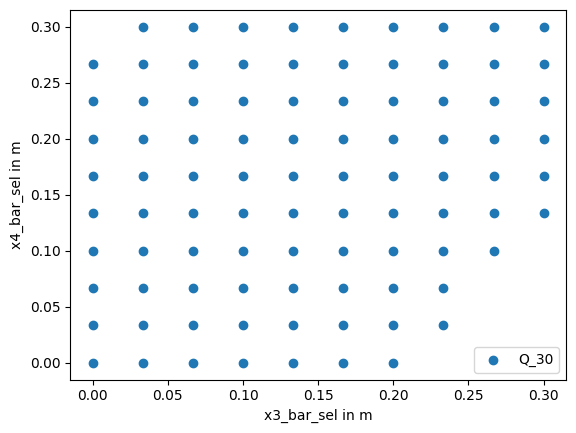

In [28]:
# Now do everything using arrays
# Assuming you have 9 arrays of size (100,)
# Let's call them Q_arrays and U_A_arrays for volume flow and voltage respectively

# Assuming Q_arrays and U_A_arrays are your 9 arrays
#x3_bar = np.linspace(0, hT3, 100)
#x4_bar = np.linspace(0, hT4, 100)
def get_all_system_ss_info(x3_bar,x4_bar):
    # here we assume that the system is always again in steady state
    Q_30 = AS30 * np.sqrt(2 * g * (x3_bar + hV3))
    Q_34 = AS34 * np.sqrt(2 * g * (x3_bar + hV3))
    Q_40 = AS40 * np.sqrt(2 * g * (x4_bar + hV4))

    x2_bar = (1 / AS24 * (Q_40 - Q_34)) ** 2 * 1 / (2 * g) - hV2
    Q_24 = AS24 * np.sqrt(2 * g * (x2_bar + hV2))
    Q_23 = AS23 * np.sqrt(2 * g * (x2_bar + hV2))

    x1_bar = (1 / AS13 * (Q_30 + Q_34 - Q_23)) ** 2 * 1 / (2 * g) - hV1
    Q_12 = AS12 * np.sqrt(2 * g * (x1_bar + hV1))
    Q_13 = AS13 * np.sqrt(2 * g * (x1_bar + hV1))

    Q_01 = Q_12 + Q_13
    Q_02 = Q_23 + Q_24 - Q_12

    U_A1 = Q_01 / Ku1 + uA01
    U_A2 = Q_02 / Ku2 + uA02
    return Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2

def get_cond(Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2):
    positive_flow_condition = np.all([Q_30 > 0, Q_34 > 0, Q_40 > 0, Q_24 > 0, Q_23 > 0, Q_12 > 0, Q_13 > 0, Q_01 > 0, Q_02 > 0], axis = 0)
    voltage_condition = np.all([U_A1 < uAmax1, U_A2 < uAmax2],axis = 0)
    return positive_flow_condition, voltage_condition

length = 100
x3_bar = np.tile(np.linspace(0,hT3,10), length // 10)
x4_bar = np.repeat(np.linspace(0,hT4,10), length //10)
Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2 = get_all_system_ss_info(x3_bar, x4_bar)

#Check conditions for positive volume flow and voltage below 12
positive_flow_condition, voltage_condition = get_cond(Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2)
#Get the indices where both conditions are satisfied
indices = np.where(positive_flow_condition & voltage_condition)

    
if indices[0].size > 0:
    # Accessing elements at the specified indices
    x3_bar_sel = x3_bar[indices]
    x4_bar_sel = x4_bar[indices]

    # Plotting Q against voltage
    plt.scatter(x3_bar_sel, x4_bar_sel, label='Q_30', marker='o')
    # Repeat this for other Q arrays

    plt.xlabel('x3_bar_sel in m')
    plt.ylabel('x4_bar_sel in m')
    plt.legend()
    plt.show()


In [29]:
# Declare functions
# Calculate the volume flow given with toricelli
# from sympy.physics.mechanics import *

# x3, x4 = dynamicsymbols('x3 x4')
def fij(aij, xi, hi):
    return aij * sp.sqrt(2 * g * (xi+hi))

# Calculate the volume flow given the pump voltage
def Q0j(K, uAj, uA0j):
    return K * (uAj - uA0j)

# Caclulate the height from given volume flow
def gij(Qij, aij, hi):
    return ( Qij / aij)**2 * 1 / (2*g) - hi

def get_system_info(x3,x4,dt):
    # get system info without assuming steady state condition
    arr_size = np.zeros(1)
    Q24 = arr_size
    Q13 = arr_size
    Q02 = arr_size
    Q01 = arr_size
    UA1 = arr_size
    UA2 = arr_size
    Q12 = arr_size
    Q30 = arr_size
    Q34 = arr_size
    Q40 = arr_size
    Q23 = arr_size
    x1 = arr_size
    x2 = arr_size
    
    
    for i in range(len(x3)-1):
        i = i+1
        Q24 =  np.append(Q24, AT4 * (x4[i]-x4[i-1])/dt - fij(AS34, x3[i], hV3) + fij(AS40,x4[i],hV4))
        x2 = np.append(x2, gij(Q24[i],AS24,hV2))
        Q13 = np.append(Q13, -fij(AS23,x2[i],hV2) + fij(AS34,x3[i],hV3) + fij(AS30,x3[i],hV3) + AT3 * (x3[i]-x3[i-1])/dt )
        x1 = np.append(x1, gij(Q13[i],AS13,hV1))
        # eq II)
        Q02= np.append(Q02, AT2 * (x2[i]-x2[i-1])/dt - fij(AS12,x1[i],hV1) + fij(AS23,x2[i],hV2) + fij(AS24,x2[i],hV2))
        # eq I)
        Q01 = np.append(Q01, AT1 * (x1[i]-x1[i-1])/dt+ fij(AS12,x1[i],hV1) + fij(AS13,x1[i],hV1))
        # Calculating the pump voltages
        UA1 = np.append(UA1, Q01[i] / Ku1 + uA01)
        UA2 = np.append(UA2, Q02[i] / Ku2 + uA02)

        # Calculate all missing volume flows
        Q12 = np.append(Q12,fij(AS12,x1[i],hV1))
        Q30 = np.append(Q30,fij(AS30,x3[i],hV3))
        Q34 = np.append(Q34,fij(AS34, x3[i], hV3))
        Q40 = np.append(Q40,fij(AS40,x4[i],hV4))
        Q23 = np.append(Q23,fij(AS23,x2[i],hV2))
    return Q30[1:], Q34[1:], Q40[1:], x2[1:], Q24[1:], Q23[1:], x1[1:], Q12[1:], Q13[1:], Q01[1:], Q02[1:], UA1[1:], UA2[1:]



# Starting off by calculating Q24
# eq IV)
# Q24 = AT4 * sp.diff(x4) - fij(AS34, x3, hV3) + fij(AS40,x4,hV4)
# x2 = gij(Q24,AS24,hV2)
# eq III) 
# Q13 = -fij(AS23,x2,hV2) + fij(AS34,x3,hV3) + fij(AS30,x3,hV3) + AT3 * sp.diff(x3) 
# x1 = gij(Q13,AS13,hV1)

# eq II)
# Q02 = AT2 * sp.diff(x2) - fij(AS12,x1,hV1) + fij(AS23,x2,hV2) + fij(AS24,x2,hV2)

# eq I)
# Q01 = AT1 * sp.diff(x1)+ fij(AS12,x1,hV1) + fij(AS13,x1,hV1)

# Calculating the pump voltages
# UA1 = Q01 / Ku1 + uA01
# UA2 = Q02 / Ku2 + uA02





U_A1[22.7513149095258 9.83357555151769 9.99058305513375 10.1407452798659
 10.2842872947267 10.4212732571875 10.5516286792864 10.6751623229740
 10.7915876202774 10.9005435193431 11.0016146575369 11.0943507597442
 11.1782851558552 11.2529523076782 11.3179042336443 11.3727257205224
 11.4170482156156 11.4505623008188 11.4730286614535 11.4842874776574
 11.4842661837903 11.4729855611841 11.4505641509150 11.4172209953290
 11.3732767392165 11.3191531430554 11.2553710812636 11.1825471174265
 11.1013887657369 11.0126885633720 10.9173170919727 10.8162150980832
 10.7103848723140 10.6008810552853 10.4888010454614 10.3752751898528
 10.2614569435619 10.1485131886919 10.0376149070760 9.92992840544098
 9.82660729552159 9.72878543623541 9.63757104984005 9.55404222966751
 9.47924406357564 9.41418760468315 9.35985092965851 9.31718253466105
 9.28710733024525 9.27053550896758 9.26837457326000 9.28154482609865
 9.31099864286024 9.35774385939860 9.42287162798977 9.50758910896636
 9.61325738041383 9.7414349600

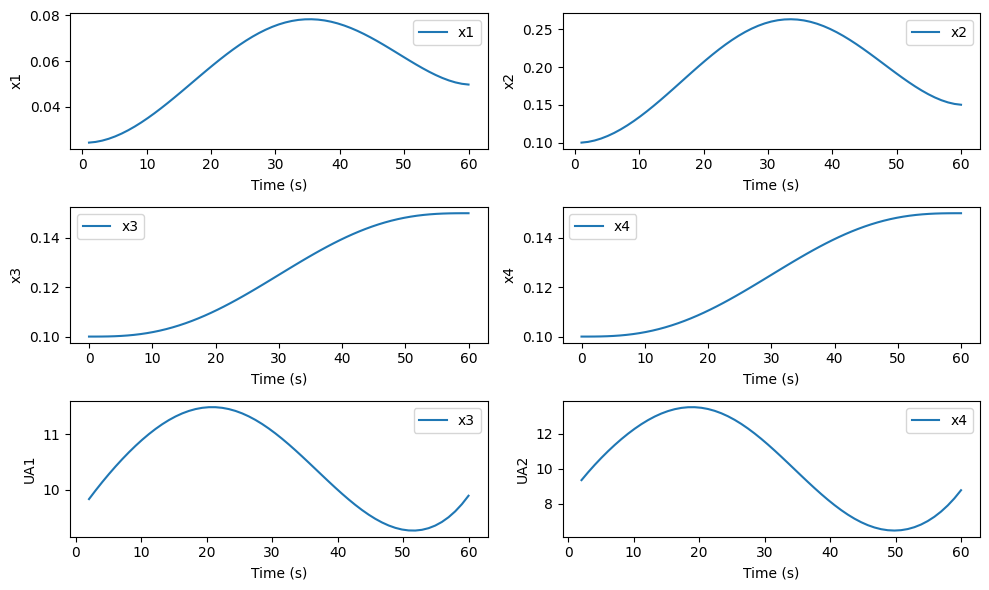

In [30]:
# flatnessbased trajectory control
def prototype_function(ti,T):
    return 30*((ti/T)**3/3 - 2*(ti/T)**4 /4 + (ti/T)**5 /5)

def get_trajectory(t,T,x_i,x_f):
    x = np.zeros((1))
    x = x_i
    for i in range(len(t)-2):
        i = i+1
        temp = x_i + (x_f - x_i)*prototype_function(t[i],T)
        x = np.append(x, temp)
    x = np.append(x,x_f)
    return x

# Now we plan x3 and x4 because they are our flat variables and with them planned in the needed smoothness we get all other variables as well
T = 60 # s transfer time
dt = 1 # s time step intervall
t = np.linspace(0,T,round(T/dt))

# initial values
x3_i = 0.1
x4_i = 0.1
# final values
x3_f = 0.15
x4_f = 0.15
# planned tajectory
x3_traj = get_trajectory(t,T,x3_i,x3_f)
x4_traj = get_trajectory(t,T,x4_i,x4_f)

# get all values of the other variables and check if the conditions are satisfied
# here we neglected the derivatives we just assumed steady states
Q_30, Q_34, Q_40, x2_traj, Q_24, Q_23, x1_traj, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2 = get_system_info(x3_traj, x4_traj,dt)
print("U_A1"+str(U_A1)+"\n" +  "U_A2" + str(U_A2))

positive_flow_condition, voltage_condition = get_cond(Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2)
# Get the indices where both conditions are satisfied
indices = np.where(positive_flow_condition & voltage_condition)

# Check conditions for all array entries
all_positive_flow_conditions_satisfied = np.all(positive_flow_condition[1:])
all_voltage_conditions_satisfied = np.all(voltage_condition[1:])

print("Positive Flow Conditions Satisfied for All Entries:", all_positive_flow_conditions_satisfied)
print("Voltage Conditions Satisfied for All Entries:", all_voltage_conditions_satisfied)


# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(3, 2, 1)
plt.plot(t[1:], x1_traj, label='x1')
plt.xlabel('Time (s)')
plt.ylabel('x1')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t[1:], x2_traj, label='x2')
plt.xlabel('Time (s)')
plt.ylabel('x2')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, x3_traj, label='x3')
plt.xlabel('Time (s)')
plt.ylabel('x3')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, x4_traj, label='x4')
plt.xlabel('Time (s)')
plt.ylabel('x4')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t[2:], U_A1[1:], label='x3')
plt.xlabel('Time (s)')
plt.ylabel('UA1')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(t[2:], U_A2[1:], label='x4')
plt.xlabel('Time (s)')
plt.ylabel('UA2')
plt.legend()
plt.tight_layout()
plt.show()


